# **TP3 : Clustering & Word2Vec** 

STIC-B545 | Traitement automatique de corpus

Antonio Pitisci | antonio.pitisci@ulb.be

## **Clustering**

### Imports

In [8]:
# Points 2-3 : Clustering
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

# Wordcloud
import yake
from collections import Counter
from wordcloud import WordCloud
from IPython.display import Image

# Points 5-7 : Word2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import wordpunct_tokenize
from unidecode import unidecode

In [9]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords') # wordcloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
data_path = "../data/txt/"

### Choisir une décennie

1. Choisissez une décennie entre 1890-1899 et 1960-1969 ➡️ 1930

In [11]:
DECADE = '1930'

In [12]:
# Charger tous les  fichiers de la décennie et en créer une liste de textes
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [13]:
# Exemple de fichiers
files[:5]

['KB_JB838_1930-01-05_01-00006.txt',
 'KB_JB838_1930-01-09_01-00001.txt',
 'KB_JB838_1930-01-09_01-00014.txt',
 'KB_JB838_1930-01-16_01-00010.txt',
 'KB_JB838_1930-01-20_01-00002.txt']

In [14]:
texts = [open(data_path + f, "r", encoding="utf-8").read() for f in files]

In [15]:
# Exemple de textes
texts[0][:400]

"15 G I C 3. L ^ SQ| R V .1- . FINANCE - INDUSTRIE - COMMERCE BOURSE de BRUXELLES I Marchés d’Anvers REVUE HEBDOMADAIRE La Eourse, qui avait très peu de chance de g.tg:v»r en aciivi.é penciant cette semaine raccourcie par le congé du Nouvel- Aii, a c i cependant une attitude qui permet de bien augurer des prochaines séances. L's capitalistes semblent enfin s’être rendu compte cours leur fou: quelqu"

### Vectoriser les documents à l'aide de TF-IDF

In [16]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

In [17]:
# Instancier le modèle TF-IDF avec ses arguments
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

In [18]:
# Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`
tfidf_vectors = vectorizer.fit_transform(texts)

c:\Users\anton\Documents\ULB\MA-STIC2\Traitement automatique de corpus\TPs\tac\tac_venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [19]:
# Détail de la matrice
tfidf_vectors

<1000x3942 sparse matrix of type '<class 'numpy.float64'>'
	with 789606 stored elements in Compressed Sparse Row format>

In [20]:
# Imprimer le vecteur tf-IDF du premier document
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

id          0.455144
janvier     0.243864
disp        0.217844
no          0.189761
ld          0.180348
              ...   
entendre    0.000000
entendu     0.000000
entente     0.000000
entière     0.000000
♦           0.000000
Length: 3942, dtype: float64

### Comprendre les vecteurs et leurs "distances"

In [21]:
cosine([1, 2, 3], [1, 2, 3])

0.0

In [22]:
cosine([1, 2, 3], [1, 2, 2])

0.02004211298777725

In [23]:
cosine([1, 2, 3], [2, 2, 2])

0.07417990022744858

### Tests sur nos documents

In [24]:
tfidf_array = tfidf_vectors.toarray()

In [25]:
# Vecteur du document 0
tfidf_array[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [26]:
# Vecteur du document 1
tfidf_array[1]

array([0.05956271, 0.        , 0.        , ..., 0.        , 0.        ,
       0.02573525])

In [27]:
cosine(tfidf_array[0], tfidf_array[1])

0.8606658574668415

### Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

2. Effectuez un clustering des documents de cette décennie, en adaptant éventuellement le nombre de clusters désirés.

In [28]:
# Définir un nombre de clusters
N_CLUSTERS = 3

In [29]:
# Instancier le modèle K-Means et ses arguments
km_model = KMeans(n_clusters=N_CLUSTERS)

In [30]:
# Appliquer le clustering à l'aide de la fonction `fit_predict`
clusters = km_model.fit_predict(tfidf_vectors)

In [31]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [32]:
pprint(dict(clustering))

{0: ['KB_JB838_1930-01-05_01-00006.txt',
     'KB_JB838_1930-01-30_01-00006.txt',
     'KB_JB838_1930-02-05_01-00005.txt',
     'KB_JB838_1930-03-01_01-00004.txt',
     'KB_JB838_1930-04-03_01-00004.txt',
     'KB_JB838_1930-04-06_01-00007.txt',
     'KB_JB838_1930-04-07_01-00003.txt',
     'KB_JB838_1930-04-09_01-00015.txt',
     'KB_JB838_1930-04-14_01-00006.txt',
     'KB_JB838_1930-04-16_01-00016.txt',
     'KB_JB838_1930-04-22_01-00006.txt',
     'KB_JB838_1930-05-18_01-00011.txt',
     'KB_JB838_1930-07-25_01-00005.txt',
     'KB_JB838_1930-07-26_01-00006.txt',
     'KB_JB838_1930-08-17_01-00004.txt',
     'KB_JB838_1930-08-21_01-00005.txt',
     'KB_JB838_1930-09-01_01-00006.txt',
     'KB_JB838_1930-09-04_01-00006.txt',
     'KB_JB838_1930-09-11_01-00005.txt',
     'KB_JB838_1930-10-12_01-00008.txt',
     'KB_JB838_1930-10-19_01-00005.txt',
     'KB_JB838_1930-11-04_01-00004.txt',
     'KB_JB838_1930-11-29_01-00019.txt',
     'KB_JB838_1930-12-01_01-00015.txt',
     'KB_JB838_1

### Visualiser les clusters

In [33]:
# Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [34]:
reduced_vectors[:10]

array([[-0.20617369,  0.00851722],
       [-0.24991349,  0.06358553],
       [ 0.01281754, -0.18086666],
       [ 0.50604625,  0.39697196],
       [-0.32169693,  0.10166622],
       [ 0.20311397, -0.49186665],
       [-0.1247206 , -0.04589017],
       [-0.26433298,  0.02043333],
       [ 0.08005685, -0.08560318],
       [ 0.25099757, -0.07204348]])

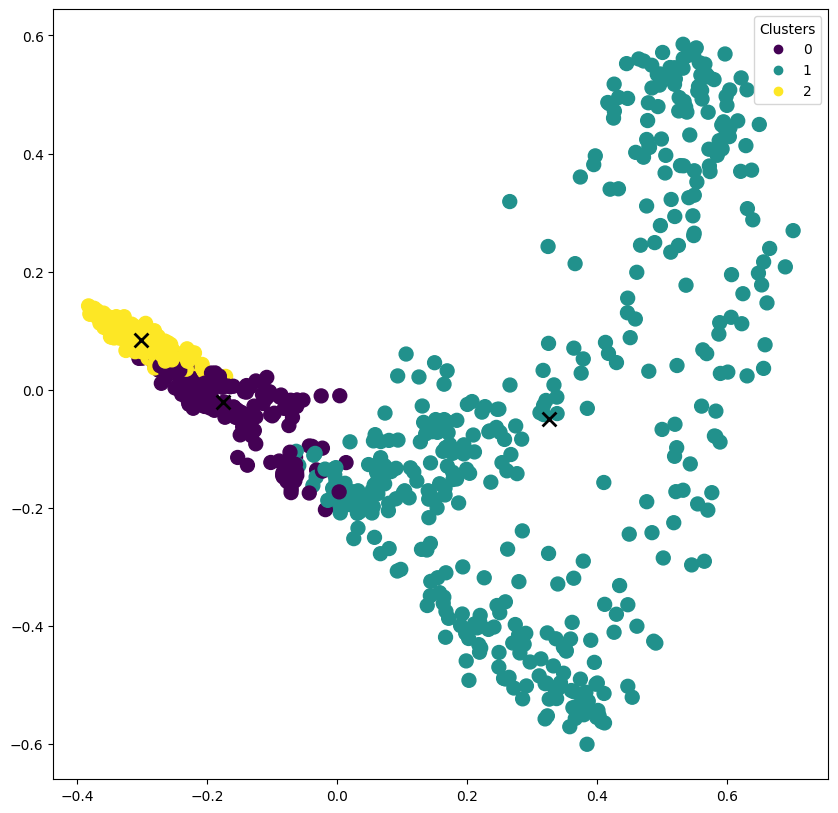

In [35]:
# Générer le plot
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

3. Tentez d'interpréter les résultats obtenus : les clusters semblent-ils faire sens? Si oui/non, comment l'expliquez-vous? Aidez-vous au besoin d'une analyse de keywords et/ou wordcloud (voir TP2).

#### Wordcloud

In [36]:
# Stopwords (Idem que dans s1)
sw = stopwords.words("french")
sw += ["les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout",
       "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous",
       "celle", "entre", "encore", "toutes", "pendant", "moins", "dire", "cela", "non",
       "faut", "trois", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres",
       "van", "het", "autre", "jusqu", "ville", "rossel", "dem"]
sw = set(sw)

In [37]:
# Identifier le chemin de vos données et spécifier le cluster à traiter
data_path = "../data/txt/"
cluster_id = 0  # changer ce numéro pour le cluster souhaité
files_in_cluster = clustering[cluster_id]  # liste des fichiers dans le cluster

# Concaténer le texte de tous les fichiers du cluster
cluster_text = " ".join([open(os.path.join(data_path, f), "r", encoding="utf-8").read() for f in files_in_cluster])

In [38]:
# Nettoyer le texte
words = nltk.wordpunct_tokenize(cluster_text)
kept_words = [w.upper() for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw]
cleaned_text = " ".join(kept_words)

# Compter les mots dans le cluster
word_counts = Counter(cleaned_text.split())

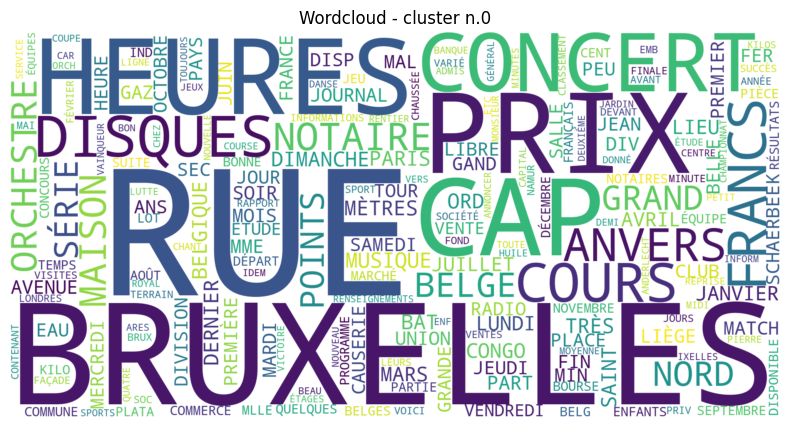

In [39]:
# Générer le wordcloud pour le cluster
wordcloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(word_counts)

# Afficher le wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f"Wordcloud - cluster n.{cluster_id}")
plt.show()

## **Word2Vec**

4. Téléchargez sur l’UV le fichier zippé sents.txt, déjà segmenté en phrases, et placez-le dans le dossier data ⬇️✔️

### Chargement et traitement des phrases du corpus

In [40]:
# Création d'un objet qui streame les lignes d'un fichier pour économiser de la RAM
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

In [41]:
infile = f"../data/sents.txt"
sentences = MySentences(infile)

### Détection des bigrams

In [42]:
bigram_phrases = Phrases(sentences)

In [43]:
type(bigram_phrases.vocab)

dict

Il contient de nombreuses clés qui sont autant de termes observés dans le corpus

In [44]:
# Clés / termes observés dans le corpus
len(bigram_phrases.vocab.keys())

4310398

In [45]:
# Prendre une clé au hasard
key_ = list(bigram_phrases.vocab.keys())[2209]
print(key_)

a_des


In [46]:
# Indiquer le score de cette cooccurrence
bigram_phrases.vocab[key_]

1962

In [47]:
# Conversion des `Phrases` en objet `Phraser`
bigram_phraser = Phraser(phrases_model=bigram_phrases)

### Extraction des trigrams

In [48]:

trigram_phrases = Phrases(bigram_phraser[sentences])

In [49]:
trigram_phraser = Phraser(phrases_model=trigram_phrases)

### Création d'un corpus d'unigrams, bigrams, trigrams

In [50]:
corpus = list(trigram_phraser[bigram_phraser[sentences]])

In [51]:
print(corpus[:100])

[['mi', 'imnri', 'r', 'i', '<<', 'i', 'i', 'hmu', "'", 'i', '/', 'tx', "-'", 'l', ':', 'marche', 'tenu', 'hors', 'villa', ',', 'la', '9', '.'], ['--', 'u', 'a', 'ete', 'vaain', 'si', 'teicj', '>>', 'm', 'races', 'indigenes', 'de', 'fr', '.'], ['31', '<)', 'a', '5s', "'", 'k', '131', 'de', '.'], ['rasa', 'iichakdui', "'", 'te', ',', 'do', '(', 'r', '.', '3s0', 'h', '710', '.', 'taureaux', 'iallsenas', ',>', 'ia', 'u', '\\', '--', 'a', '--', ';', '0ii', '.'], ['hollandais', ',', 'dufr', '.'], ['0', '.'], ['--', 'a', '9', '.--', 'la', 'idto', '-', 'vachei', 'laitieres', ':', 'bn', 'vante', '1q', '.'], ['vendues', '3', '\\', 'au', 'prix', 'la', '410', 'a', '*', '<<', 'i', 'h', '\\;', 'genisses', ',', 'kl', '.'], ["'.", '9', '.'], ['i', 'l', '.', '2', 'i', '.', 'id', '.'], ['da', '370', 'i', '6lutr', '.'], ['marche', 'a', '<', 'u', 'porcs', '.'], ['--', 'categorie', 'de', 'lt', 'ilashtya', ':', "'", '237', 'on', 'vente', ';', 'vendus', '1', 'm', '.', 'do', "'", '2', 'i', '.--', 'a', ';:,', 

### Entrainement d'un modèle Word2Vec sur ce corpus
5. Entraînez un modèle word2vec (word embeddings) sur ces phrases grâce au notebook s3_word_embeddings.ipynb, en adaptant éventuellement les paramètres window (taille de la fenêtre) et min_count (nombre minimum d’occurrences d’un mot)

In [52]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=7, # La taille du "contexte", ici 7 mots avant et après le mot observé
    min_count=3, # On ignore les mots qui n'apparaissent pas au moins 3 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descente de gradient, aka. epochs.
)

CPU times: total: 1min 40s
Wall time: 38.8 s


In [53]:
#  Sauver le modèle dans un fichier
outfile = f"../data/balanced.model"
model.save(outfile)

6. Vous pouvez entraîner plusieurs modèles afin de comparer leurs performances, en procédant par essais-erreurs pour choisir le meilleur modèle

J'ai entraîné 4 modèles avec les paramètres suivants : 
- "default" : window=5, min_count=5 ;
- "global_r" : window=15, min_count=10 ;
- "local_r" : window=3, min_count=1 ;
- "balanced" : window=7, min_count=3 ;

### Explorer le modèle
7. Explorez le modèle retenu à l’aide des fonctions similarity et most_similar (choisissez au moins trois exemples pour chaque fonction)

In [54]:
# Charger le modèle en mémoire
model = Word2Vec.load("../data/balanced.model")

In [55]:
# Termes présents dans les 3 exemples pris en considération
termes_ex = ["vente", "achat", "agence", "maison", "championnat", "orchestre"] # liste avec les termes issus des 3 exemples

# Imprimer le vecteur de chaque terme présent dans les 3 exemples sélectionnés
for terme in termes_ex:
    print(f"{terme} :", model.wv[terme])
    print()

vente : [-3.3426156  -0.06763799 -1.2208813  -2.7706501   2.223226    1.5070785
 -2.9781933  -3.7919772  -3.721127   -2.2582664   2.9109943  -0.23557036
  4.9858885   2.8811176   5.5784087   0.35152268 -0.40054753 -9.723031
 -3.5091782  -2.4731631   1.0106077   2.8486927   1.0894308   3.5372214
  2.4272406  -0.01832341 -0.50313103 -1.0384691  -0.7675172   0.6177044
 -6.2576466  -0.952475  ]

achat : [-1.5272194  -2.5671172  -1.378791   -1.2058588   3.1747482   1.7951558
 -1.5524395  -1.936545   -2.5618072  -0.78465587  2.8278193  -1.9037532
  3.447113    2.042122    3.3293731  -2.3919373   0.7825838  -3.1865346
 -2.956242   -1.1152979  -2.4228806   1.2602965  -0.7384983   1.1966087
  3.206116   -0.58788365 -2.5296295   6.0421076   1.191683    1.8188113
 -2.1953075   0.40014297]

agence : [-2.6843967  -2.084522    1.7899934   1.4673926   0.47243094 -0.59413093
  1.6320119   2.8357046  -2.392273   -2.2758222   0.65790117  1.1788427
  1.5543491   1.0646752  -1.2610912  -1.3341676  -1.7345

In [56]:
# Calculer la similarité entre les termes
similarité_ex1 = model.wv.similarity("vente", "achat") # Exemple 1 : relation évidente
similarité_ex2 = model.wv.similarity("agence", "maison") # Exemple 2 : relation indirecte
similarité_ex3 = model.wv.similarity("championnat", "orchestre") # Exemple 3 : relation inexistante

# Affichage des résultats
print("vente - achat :", similarité_ex1)
print()
print("agence - maison :", similarité_ex2)
print()
print("championnat - orchestre :", similarité_ex3)

vente - achat : 0.6552874

agence - maison : 0.08707894

championnat - orchestre : 0.4975906


In [57]:
# Parcourir la liste des termes et chercher les 10 mots les plus proches pour chacun d'entre eux
for terme in termes_ex:
    print(f"Les mots les plus proches de '{terme}' sont :")
    similar_terms = model.wv.most_similar(terme, topn=10)
    for similar_term, similarity in similar_terms:
        print(f"- '{similar_term}', {similarity:.4f}")
    print()

Les mots les plus proches de 'vente' sont :
- 'location', 0.8400
- 'liquidation', 0.7745
- 'vente_publique', 0.7230
- 'paiement', 0.7156
- 'mise_en_vente', 0.7142
- 'fabrique', 0.7010
- 'sans_frais', 0.6971
- 'plusieurs_titres', 0.6903
- 'choix', 0.6798
- 'payement', 0.6711

Les mots les plus proches de 'achat' sont :
- 'soldes', 0.8161
- 'pianos', 0.7955
- 'mobiliers', 0.7913
- 'location', 0.7877
- 'beaux_vetements', 0.7857
- 'toutes_especes', 0.7800
- 'velos', 0.7717
- 'choix', 0.7692
- 'rabais', 0.7638
- 'en_solde', 0.7620

Les mots les plus proches de 'agence' sont :
- 'agence_rossel', 0.8777
- 'agonco', 0.8072
- 'vagence', 0.7835
- 'ecrire_agence', 0.7597
- 'agenco', 0.7559
- 'agehee', 0.7472
- 'agenre', 0.7352
- 'ag', 0.7313
- 'agence_rossel_sous', 0.7280
- 'genco', 0.7221

Les mots les plus proches de 'maison' sont :
- 'grande_maison', 0.7761
- 'une_maison', 0.7689
- 'jolie_maison', 0.7484
- 'bonne_maison', 0.7459
- 'propriete', 0.7349
- 'belle_maison', 0.7289
- 'maillon', 0.724

In [58]:
# Faire des recherches complexes à travers l'espace vectoriel

recherche_1 = model.wv.most_similar(positive=["vente", "achat"], negative=["agence"], topn=5)
print("Exemple 1 : Trouver un mot qui relie la relation entre 'vente' et 'achat', en excluant la notion d''agence'.")
for word, similarity in recherche_1:
    print(f"- {word}, {similarity:.4f}")
print()

recherche_2 = model.wv.most_similar(positive=["maison", "orchestre"], topn=5)
print("Exemple 2 : Trouver un mot qui puisse associer le concept de 'maison' à celui d''orchestre'")
for word, similarity in recherche_2:
    print(f"- {word}, {similarity:.4f}")
print()

recherche_3 = model.wv.most_similar(positive=["championnat"], negative=["orchestre"], topn=5)
print("Exemple 3 : Trouver des idées liéés au concept de 'championnat' (sport), en excluant la notion d''orchestre'.")
for word, similarity in recherche_3:
    print(f"- {word}, {similarity:.4f}")
print()

Exemple 1 : Trouver un mot qui relie la relation entre 'vente' et 'achat', en excluant la notion d''agence'.
- location, 0.7680
- marchandises, 0.7405
- choix, 0.7346
- mise_en_vente, 0.7202
- sans_frais, 0.7176

Exemple 2 : Trouver un mot qui puisse associer le concept de 'maison' à celui d''orchestre'
- une_maison, 0.7300
- industriel, 0.6843
- musique, 0.6783
- 88m, 0.6697
- hotel_communal, 0.6553

Exemple 3 : Trouver des idées liéés au concept de 'championnat' (sport), en excluant la notion d''orchestre'.
- vinai, 0.7696
- banme, 0.7544
- ajournee, 0.7453
- meuie, 0.7425
- <{, 0.7351

